# Modeling the Model

Lets see exactly where we end up with the most/least error

In [1]:
import os

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.models.eval import predict_values
from optpresso.data.partition import find_test_paths

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from keras.models import load_model

from IPython.core.display import display

In [2]:
# Because GPUs aren't that much faster for inference
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# For better accuracy use a validation/test set
DATA_DIR = os.path.expanduser("~/coffee-images/train")

model = load_model(os.path.expanduser("~/proj/batch-weighted-fold-5.h5"), compile=False)

loader = GroundsLoader(128, (model.input_shape[1], model.input_shape[2]), directory=DATA_DIR)

In [7]:
paths, y_true, y_pred = predict_values(model, loader)

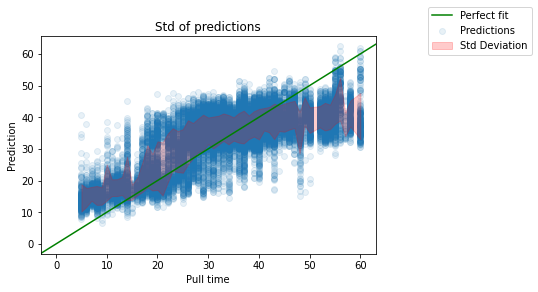

In [46]:
bins = defaultdict(list)
for real, pred in zip(y_true, y_pred):
    bins[real].append(pred)

x = np.zeros(len(bins))
y = np.zeros(len(bins))
deviations = np.zeros(len(bins))
for i, (time, predictions) in enumerate(sorted(bins.items(), key=lambda x: x[0])):
    x[i] = time
    y[i] = np.mean(predictions)
    deviations[i] = np.std(predictions)
fig, ax = plt.subplots()
ax.axline([0, 0], [1, 1], color="g", label="Perfect fit")
ax.scatter(y_true, y_pred, alpha=.1, label="Predictions")
ax.fill_between(x, (y-deviations), (y+deviations), color='r', alpha=.2, label="Std Deviation")
ax.set_ylabel("Prediction")
ax.set_xlabel("Pull time")
ax.set_title("Std of predictions")
fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

In [38]:
stacked_data = np.dstack((paths, y_true, y_pred))
stacked_data.resize(len(paths), 3)
sort = np.argsort(stacked_data[:,1])
sorted_data = stacked_data[sort]

### Investigate the inability to distinguish between 30s and 50s shots

A problem I have noticed is that the model has issues learning the difference between a 30 second shot and a 50 second shot. This investigated the point at which that distinction has the biggest impact on the MSE/MAD

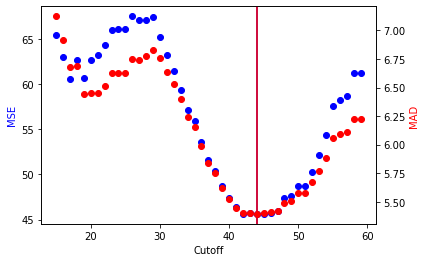

Cutoff with lowest MSE (44, 45.6333116975184)
Cutoff with lowest MAD (44, 5.392765986093178)


In [40]:
mse_data = []
mad_data = []
x = np.arange(15, 60, 1)
min_mse_cutoff = None
min_mad_cutoff = None
for cutoff in x:
    idx = 0
    for i in range(len(paths)):
        if sorted_data[i][1] > cutoff:
            idx = i
            break
    trimmed_x = sorted_data[:,1][:idx]
    trimmed_y = sorted_data[:,2][:idx]
    if not len(trimmed_x):
        continue
    mse_data.append(mean_squared_error(trimmed_x, trimmed_y))
    mad_data.append(mean_absolute_error(trimmed_x, trimmed_y))
    if min_mse_cutoff is None or mse_data[-1] < min_mse_cutoff[1]:
        min_mse_cutoff = (cutoff, mse_data[-1])
    if min_mad_cutoff is None or mad_data[-1] < min_mad_cutoff[1]:
        min_mad_cutoff = (cutoff, mad_data[-1])
plt.scatter(x, mse_data, label="MSE", color="blue")
axe = plt.gca()
axe.set_xlabel("Cutoff")
axe.set_ylabel("MSE", color="blue")
axe.axvline(min_mse_cutoff[0], color="blue")
axe_2 = axe.twinx()
axe_2.scatter(x, mad_data, label="MAD", color="red")
axe_2.set_ylabel("MAD", color="red")
axe_2.axvline(min_mad_cutoff[0], color="red")
plt.show()
print("Cutoff with lowest MSE", min_mse_cutoff)
print("Cutoff with lowest MAD", min_mad_cutoff)